# Import the necessary libraries

In [19]:
import torch
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import os

# Load the MNIST dataset

In [174]:
# Make torch deterministic
_ = torch.manual_seed(0)

In [177]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.2861,), (0.3530,))])

# Load the MNIST dataset
fmnist_trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
# Create a dataloader for the training
train_loader = torch.utils.data.DataLoader(fmnist_trainset, batch_size=10, shuffle=True)

# Load the MNIST test set
fmnist_testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(fmnist_testset, batch_size=10, shuffle=True)

# Define the device
device = "cpu"

In [178]:
#check the size and shape
image, label = next(iter(train_loader))
classes = fmnist_trainset.classes
print(image.shape, label.shape)

torch.Size([10, 1, 28, 28]) torch.Size([10])


Text(0.5, 1.0, 'Label: Shirt')

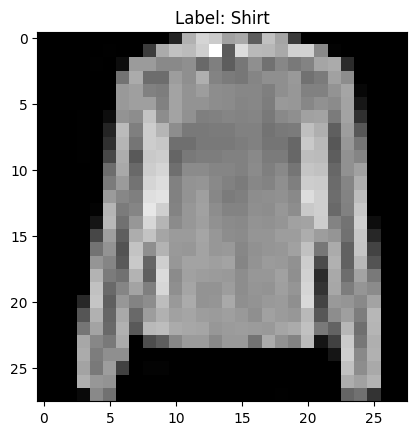

In [118]:
idx = 1
plt.imshow(image[idx].permute(1,2,0), cmap='gray')
plt.title(f'Label: {classes[label[idx].item()]}')

# Define the model

In [179]:
#lets use a pretrained resnet18 model

from torchvision.models import ResNet18_Weights

model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
# Modify the model to fit the FashionMNIST dataset
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(512, 10)

In [180]:
net = model
net.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [181]:
#sanity check
image, label = next(iter(train_loader))
output = net(image.to(device))
print(output[3])

tensor([-0.5611, -1.5845,  1.0030,  1.0037, -1.8422,  0.1038,  1.2024, -0.0512,
         0.6701,  0.1114], grad_fn=<SelectBackward0>)


# Train the model

In [182]:
def train(train_loader, net, epochs:int = 5, total_iterations_limit: int = None):
    cross_el = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    total_iterations = 0

    for epoch in range(epochs):
        net.train()

        loss_sum = 0
        num_iterations = 0

        data_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}')
        if total_iterations_limit is not None:
            data_iterator.total = total_iterations_limit
        for data in data_iterator:
            num_iterations += 1
            total_iterations += 1
            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = net(x)
            loss = cross_el(output, y)
            loss_sum += loss.item()
            avg_loss = loss_sum / num_iterations
            data_iterator.set_postfix(loss=avg_loss)
            loss.backward()
            optimizer.step()

            if total_iterations_limit is not None and total_iterations >= total_iterations_limit:
                return
            
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp_delme.p")
    print('Size (KB):', os.path.getsize("temp_delme.p")/1e3)
    os.remove('temp_delme.p')

MODEL_FILENAME = 'smnist_ptq.pt'

if Path(MODEL_FILENAME).exists():
    net.load_state_dict(torch.load(MODEL_FILENAME))
    print('Loaded model from disk')
else:
    train(train_loader, net, epochs=1)
    # Save the model to disk
    torch.save(net.state_dict(), MODEL_FILENAME)

Loaded model from disk


# Define the testing loop

In [184]:
def test(model: nn.Module, total_iterations: int = None) -> None:
    correct = 0
    total = 0

    iterations = 0

    model.eval()

    with torch.no_grad():
        for data in tqdm(test_loader, desc='Testing'):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct +=1
                total +=1
            iterations += 1
            if total_iterations is not None and iterations >= total_iterations:
                break
    print(f'Accuracy: {round(correct/total, 3)}')

# Print weights and size of the model before quantization

In [186]:
# Print the weights matrix of the model before quantization
print('Weights before quantization')
print(net.conv1.weight[0])
print(net.conv1.weight.dtype)

Weights before quantization
tensor([[[-0.0849, -0.1300, -0.0509,  0.0927, -0.0406, -0.0344,  0.0132],
         [ 0.0516,  0.1093, -0.0853, -0.0719, -0.1049,  0.0262, -0.1976],
         [-0.0052,  0.0422, -0.0612,  0.1085,  0.1315, -0.1772, -0.1539],
         [-0.1047, -0.0052, -0.0385,  0.1363,  0.0843, -0.1121, -0.1579],
         [-0.0150,  0.0024,  0.1148,  0.1397,  0.0339, -0.1615, -0.2500],
         [ 0.0935, -0.0800,  0.0848,  0.0522,  0.0980, -0.0620, -0.0535],
         [-0.0837,  0.0536, -0.1011,  0.1049,  0.0879, -0.0275,  0.0883]]],
       grad_fn=<SelectBackward0>)
torch.float32


In [187]:
print('Size of the model before quantization')
print_size_of_model(net)

Size of the model before quantization
Size (KB): 44778.497


In [188]:
print('Accuracy of the model before quantization: ')
test(net)

Accuracy of the model before quantization: 


Testing: 100%|██████████| 1000/1000 [00:06<00:00, 154.24it/s]

Accuracy: 0.85


# Apply the quantization observers and config

In [189]:
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx

In [190]:
example_input = torch.randn(1, 1, 28, 28) # dummy input for quantization
torch.backends.quantized.engine = 'qnnpack' # change it for 'fbgemm' if you want to use that backend
qconfig = torch.ao.quantization.get_default_qconfig(torch.backends.quantized.engine) # define the backend configuration
model_prepared = prepare_fx(net, {'': qconfig}, example_input) # prepare the model for quantization
model_prepared.eval()


/Users/vishalkagade/.pyenv/versions/3.10.9/lib/python3.10/site-packages/torch/ao/quantization/fx/prepare.py:1536: UserWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping instead.
  warnings.warn(


GraphModule(
  (activation_post_process_0): HistogramObserver(min_val=inf, max_val=-inf)
  (conv1): ConvReLU2d(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(inplace=True)
  )
  (activation_post_process_1): HistogramObserver(min_val=inf, max_val=-inf)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (activation_post_process_2): HistogramObserver(min_val=inf, max_val=-inf)
  (layer1): Module(
    (0): Module(
      (conv1): ConvReLU2d(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (1): Module(
      (conv1): ConvReLU2d(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [191]:
# Run a few iterations to calibrate the model
with torch.inference_mode():
    for i, (x, _) in enumerate(train_loader):
        model_prepared(x.to(device))
        if i >= 20:
            break

In [192]:
# Convert the prepared model to a quantized model
model_quantized = convert_fx(model_prepared).eval().to(device)

In [173]:
torch.save(model_quantized.state_dict(), "model_quantized.pth")

In [193]:
print(f'Check statistics of the various layers')
model_quantized

Check statistics of the various layers


GraphModule(
  (conv1): QuantizedConvReLU2d(1, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.01053610723465681, zero_point=0, padding=(3, 3))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Module(
    (0): Module(
      (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.005437065847218037, zero_point=0, padding=(1, 1))
      (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.01702350564301014, zero_point=131, padding=(1, 1))
    )
    (1): Module(
      (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.005541318561881781, zero_point=0, padding=(1, 1))
      (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.02067071571946144, zero_point=136, padding=(1, 1))
    )
  )
  (layer2): Module(
    (0): Module(
      (conv1): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(2, 2), scale=0.007975183427333832, zero_point=0, pad

# Compare the dequantized weights and the original weights

In [202]:
print('Original weights: ')
print(net.conv1.weight)  # Display only a small part of the weights for clarity
print('')
print('Dequantized weights: ')
print(torch.dequantize(model_quantized.conv1.weight()))  # Display only a small part of the dequantized weights for clarity
print('')

Original weights: 
Parameter containing:
tensor([[[[-8.4941e-02, -1.2996e-01, -5.0867e-02,  ..., -4.0584e-02,
           -3.4440e-02,  1.3186e-02],
          [ 5.1589e-02,  1.0929e-01, -8.5269e-02,  ..., -1.0493e-01,
            2.6219e-02, -1.9757e-01],
          [-5.2159e-03,  4.2154e-02, -6.1159e-02,  ...,  1.3154e-01,
           -1.7724e-01, -1.5392e-01],
          ...,
          [-1.4976e-02,  2.3904e-03,  1.1481e-01,  ...,  3.3922e-02,
           -1.6151e-01, -2.4998e-01],
          [ 9.3454e-02, -7.9977e-02,  8.4802e-02,  ...,  9.8006e-02,
           -6.1979e-02, -5.3476e-02],
          [-8.3698e-02,  5.3649e-02, -1.0112e-01,  ...,  8.7942e-02,
           -2.7515e-02,  8.8286e-02]]],


        [[[ 2.5470e-02, -1.1542e-02,  1.5714e-01,  ...,  1.1039e-04,
           -1.3876e-01, -2.2174e-02],
          [-9.1518e-02,  2.7622e-02, -5.5239e-02,  ..., -6.4452e-02,
           -1.4995e-01,  1.0194e-01],
          [-6.6572e-02,  8.0790e-03,  4.7098e-03,  ...,  6.3358e-02,
           -4.5

# Print size and accuracy of the quantized model

In [203]:
print('Size of the model after quantization')
print_size_of_model(model_quantized)

Size of the model after quantization
Size (KB): 11216.877


In [204]:
print('Testing the model after quantization')
test(model_quantized)

Testing the model after quantization


Testing: 100%|██████████| 1000/1000 [00:09<00:00, 106.91it/s]

Accuracy: 0.848
